In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

import sys
sys.path.append('/code/')
from thalamus_merfish_analysis import abc_load as abc
from thalamus_merfish_analysis import ccf_images as cimg
from thalamus_merfish_analysis import ccf_plots as cplots

from matplotlib import rcParams
rcParams['ps.fonttype'] = 42
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 7

import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline') 

In [3]:
results_dir = '../../results'

In [4]:
obs_wmb = abc.get_combined_metadata()
obs_th = abc.load_standard_thalamus(data_structure='obs')

In [5]:
# set spatial column names to `_reconstructed` coordinate space
coords = '_reconstructed'

x_col = 'x'+coords
y_col = 'y'+coords
section_col = z_col = 'z'+coords

In [6]:
# Load the CCF structures image
ccf_images = abc.get_ccf_labels_image()

# Precompute boundaries to use multiple times in this notebook w/o need to recompute
# we only need to load the boundaries for sections that contain the thalamus
sections_all = sorted(obs_th[section_col].unique())
sections_int = np.rint(np.array(sections_all)/0.2).astype(int)

# precompute boundaries for thalamic sections
ccf_boundaries = cimg.sectionwise_label_erosion(ccf_images, distance_px=1, 
                                                fill_val=0, return_edges=True, 
                                                section_list=sections_int
                                                )

In [7]:
# We can load & use the published color palettes for the ABC Atlas taxonomy
abc_palettes = {level: abc.get_taxonomy_palette(level) for level in 
                ['neurotransmitter','class', 'subclass','supertype','cluster']}

# We have also provided a secondary color palette for the cluster level that 
# attempts to increase the color contrast between spatially negihboring clusters
abc_palettes['cluster'] = abc.get_thalamus_cluster_palette() #dict(zip(palette_df['Unnamed: 0'], palette_df['0']))

ccf_palette = abc.get_ccf_palette('substructure')
ccf_palette['ZI'] = ccf_palette.pop('ZI-unassigned') # need to fix a key error

In [8]:
# if you reload thalamus_merfish_analysis.ccf_plots after this cell has been run, 
# cplots.CCF_REGIONS_DEFAULT will be reset to None & you'll need to re-run this cell
cplots.CCF_REGIONS_DEFAULT = abc.get_thalamus_names()

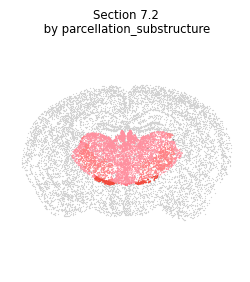

In [9]:
# downsample non-TH cells to minimize num of points rendered
obs_nonTH = obs_wmb.drop(obs_th.index, axis=0)
obs_nonTH = obs_nonTH.sample(frac=0.1, random_state=0)

kwargs_celltypes = dict(boundary_img=ccf_boundaries,
                        bg_cells=obs_nonTH, # background cells are displayed in grey
                        section_col=section_col,
                        x_col=x_col, 
                        y_col=y_col,
                        edge_color='white',
                        point_size=1, # cell marker size
                       )


taxonomy_level = 'class'
subset_fig = cplots.plot_ccf_overlay(
    obs_th.sample(frac=0.5, random_state=0), 
    ccf_images, 
    point_hue='parcellation_substructure',
    sections=[cplots.TH_EXAMPLE_Z_SECTIONS[1]],
    separate_figs=True, # False does NOT show bg_cells
    point_palette=ccf_palette,#abc_palettes[taxonomy_level],
    legend=None, #'cells',
    figsize=(20, 5),
    custom_xy_lims=[0, 11, 11, 0],
    **kwargs_celltypes
)
subset_fig[0].set_size_inches(3, 3)
subset_fig[0].savefig(f'{results_dir}/fig1A_subset_of_abc_atlas.pdf', 
                          transparent=True, bbox_inches='tight')